In [48]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import os

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [49]:
species_features_paths = {"binary": "../../data/features/plant/binary/features_by_network",
                         "weighted": "../../data/features/plant/weighted/features_by_network/",
                         "binarized_weighted": "../../data/features/plant/binarized_weighted/features_by_network/"}

species_features_output_paths = {"binary": "../../data/features/plant/binary/features.csv",
                         "weighted": "../../data/features/plant/weighted/features.csv",
                         "binarized_weighted": "../../data/features/plant/binarized_weighted/features.csv"}

network_features_dirs = {"binary": "../../data/features/network/binary/features_by_network/",
                         "weighted": "../../data/features/network/weighted/features_by_network/",
                         "binarized_weighted": "../../data/features/network/binarized_weighted/features_by_network/"}

network_features_output_paths = {"binary": "../../data/features/network/binary/features.csv",
                         "weighted": "../../data/features/network/weighted/features.csv",
                         "binarized_weighted": "../../data/features/network/binarized_weighted/features.csv"}

features_of_interest = {"plant": ["partner.diversity", "d", "normalised.degree", "weighted.betweenness", "weighted.closeness"],
                        "network": ["connectance", "NODF", "modularity", "robustness", "robustness_mean", "robustness.LL"]}

species_features_dir = "../../data/features/plant/"
network_features_dir = "../../data/features/network/"

# standarize species features using the rankiong approach of Stouffer et al. 2014

In [50]:
alternative_features_df = []
for network_type in species_features_output_paths:
    features_dir = f"{species_features_dir}{network_type}/"
    if os.path.exists(species_features_output_paths[network_type]):
        features_df = pd.read_csv(species_features_output_paths[network_type])
        features_df["network_type"] = network_type
        alternative_features_df.append(features_df)
    else:
        altenative_paths = {int(p.replace("_features.csv", "")): f"{features_dir}{p}" for p in os.listdir(features_dir) if p.endswith("_features.csv")}
        for p in altenative_paths:
            df = pd.read_csv(altenative_paths[p]).rename(columns={"Unnamed: 0": "Plant"})
            df["network_id"] = int(p)
            df["network_type"] = network_type
            alternative_features_df.append(df)
alternative_features_df = pd.concat(alternative_features_df)
alternative_features_df = alternative_features_df[[c for c in alternative_features_df.columns if not c.startswith("standardized_ ")]]

In [51]:
def get_ranked_features_df(df: pd.DataFrame) -> pd.DataFrame:
    if df.shape[0] == 0:
        return df
    features = [c for c in df.columns if not c.startswith("standardized_") and c not in ["Plant", "network", "network_id", "network_type"]]
    
    for feature in features:
        df[f"standardized_{feature}"] = df[feature].rank()
        max_rank = df[f"standardized_{feature}"].max()
        df[f"standardized_{feature}"] = df[f"standardized_{feature}"] / max_rank
    
    return df

alternative_features_df = alternative_features_df.rename(columns={"network": "network_id"}).groupby(["network_type", "network_id"]).parallel_apply(lambda df: get_ranked_features_df(df))

In [52]:
standardized_features = [c for c in alternative_features_df.columns if c.startswith("standarized")]
for f in standardized_features:
    assert(alternative_features_df[f].max() <= 1)
    assert(alternative_features_df[f].max() >= 1)

In [53]:
alternative_features_df.reset_index(inplace=True, drop=True)

In [54]:
for network_type in species_features_output_paths:
    alternative_features_df.query(f"network_type == '{network_type}'").to_csv(species_features_output_paths[network_type])

In [55]:
alternative_features_df = pd.concat([pd.read_csv(species_features_output_paths[network_type]) for network_type in species_features_output_paths])

In [56]:
test = alternative_features_df.query("network_type == 'binary' and network_id == 1")[["Plant", "degree","normalised.degree", "standardized_degree", "standardized_normalised.degree"]].sort_values("degree")

features = ['normalised.degree', 'weighted.betweenness', 'd', 'partner.diversity', 'weighted.closeness']


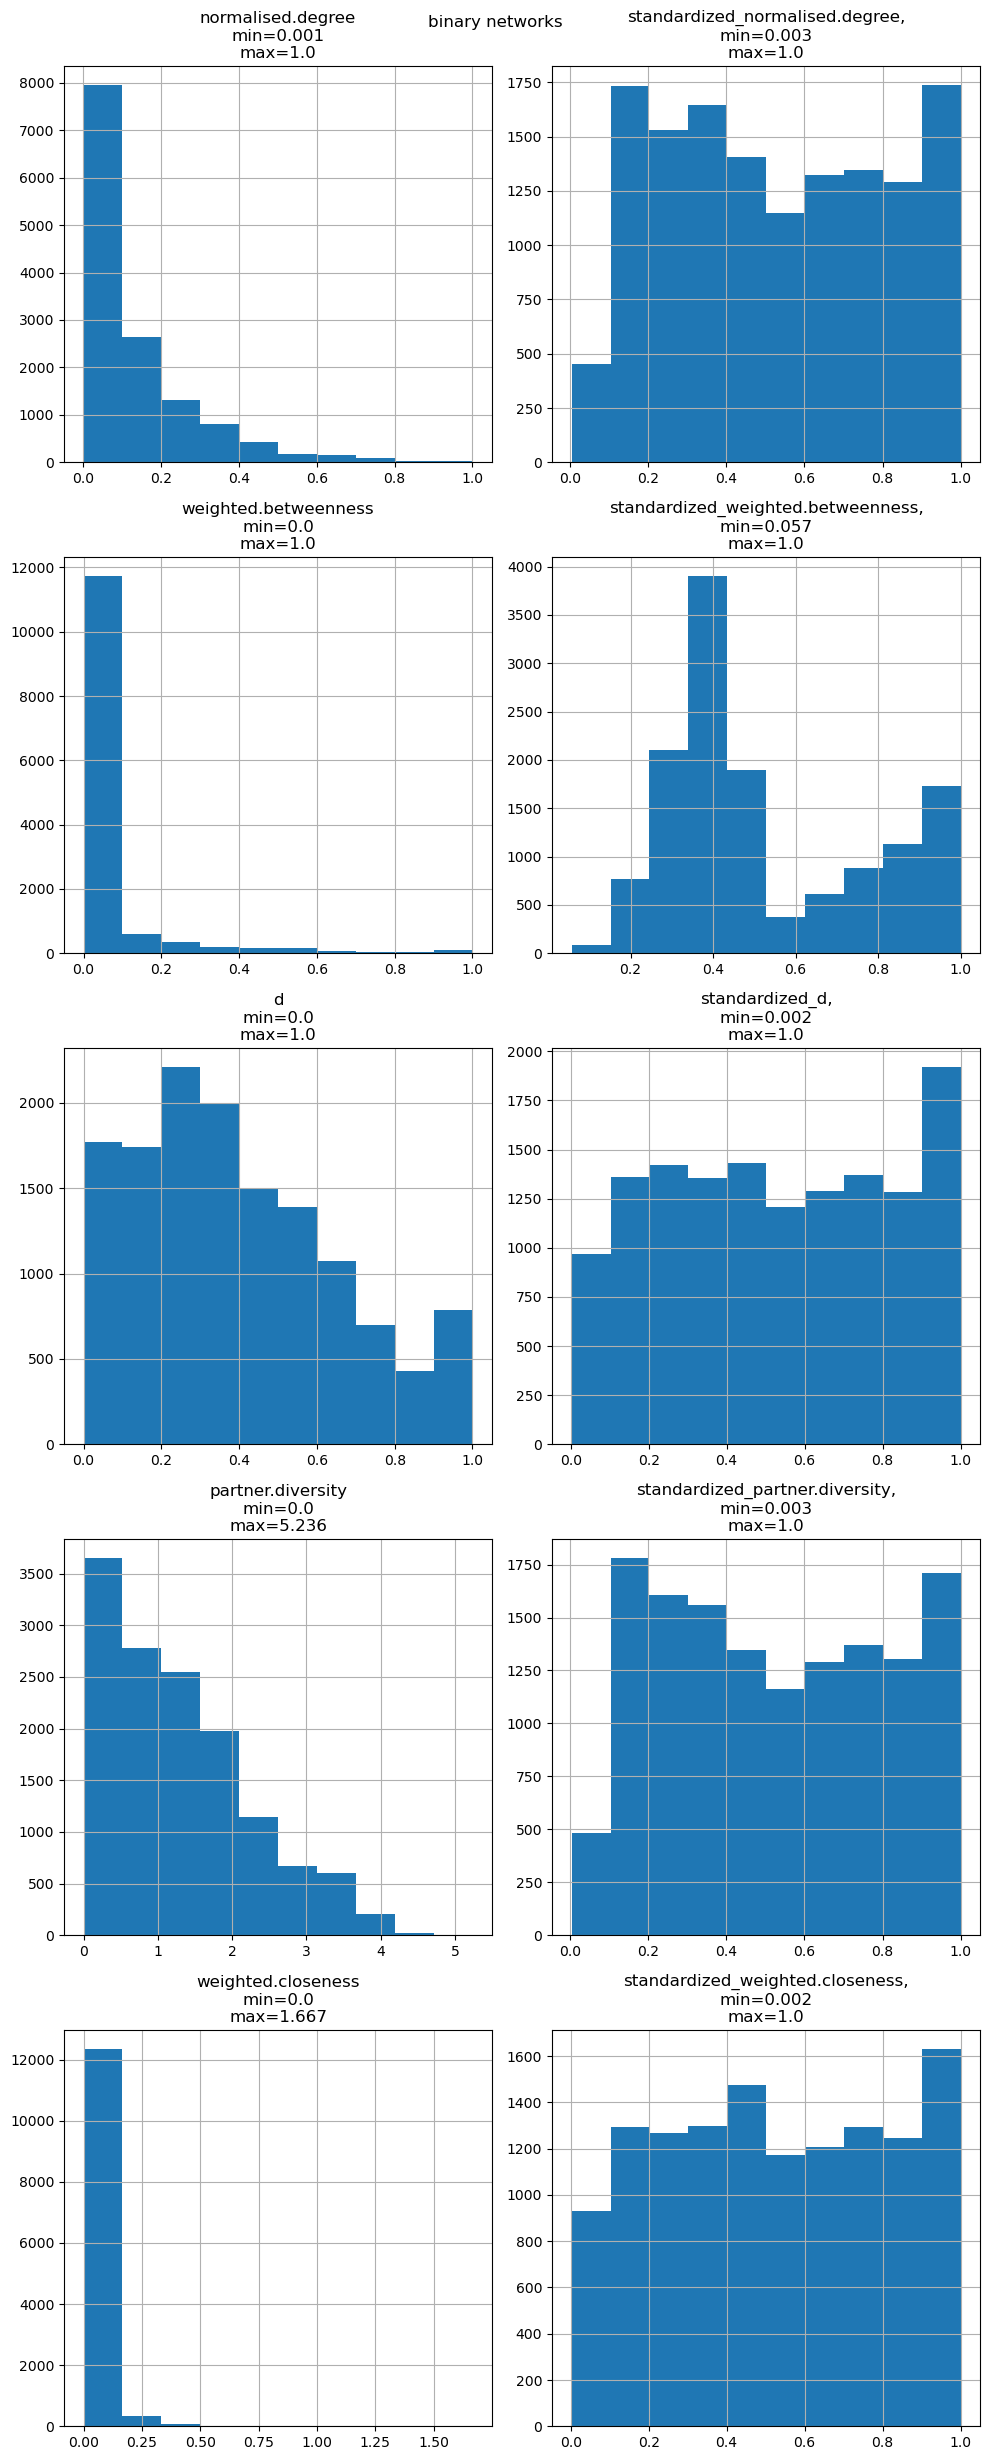

In [57]:
import matplotlib.pyplot as plt
features_to_examine = list(set(features_of_interest["plant"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("binar")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"binary networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"standardized_{f}" in relevant_features.columns:
        relevant_features[f"standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"standardized_{f},\nmin={np.round(relevant_features[f'standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{species_features_dir}/binary_networks_based_feature_distribution.jpeg")

features = ['normalised.degree', 'weighted.betweenness', 'd', 'partner.diversity', 'weighted.closeness']


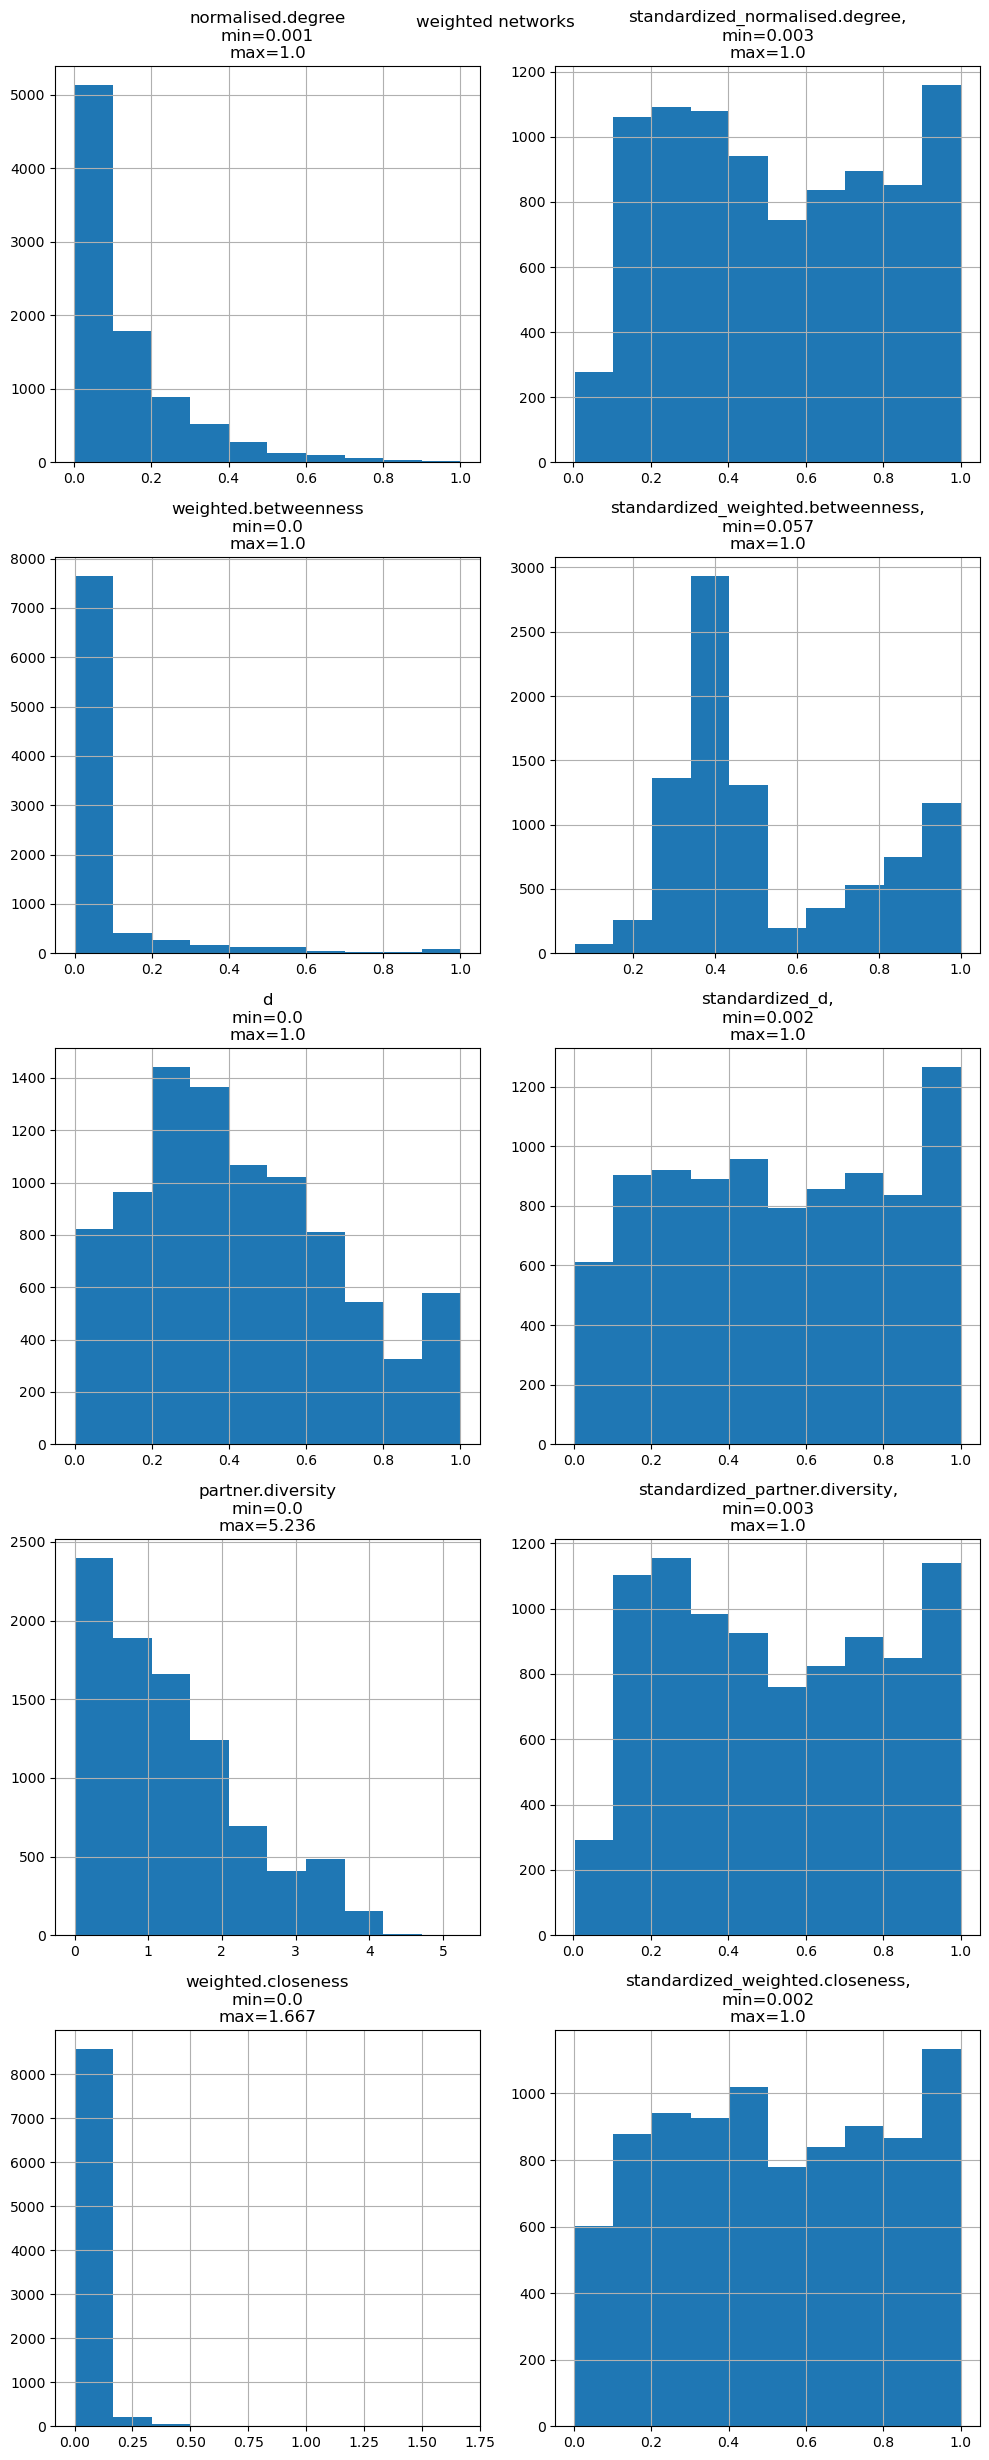

In [58]:
import matplotlib.pyplot as plt
features_to_examine = list(set(features_of_interest["plant"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("weighted")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"weighted networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"standardized_{f}" in relevant_features.columns:
        relevant_features[f"standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"standardized_{f},\nmin={np.round(relevant_features[f'standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{species_features_dir}/weighted_networks_based_feature_distribution.jpeg")

# standarize network features using delta transformation 

In [28]:
def get_standardized_feature(feature, network_id, network_type, alt_val, null_vals):
    if len(null_vals) == 0:
        print(f"no null values available for feature {feature} in {network_type} network {network_id}")
        return np.nan
    return (alt_val-np.mean(null_vals))
    # all_vals = pd.Series([alt_val] + list(null_vals)).dropna()
    # return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
    
def add_standardized_features(altenative_features_path: str, null_features_path: str, network_type:str) -> pd.DataFrame:
    alt_db = pd.read_csv(altenative_features_path)
    alt_db = alt_db[[c for c in alt_db.columns if not c.startswith("delta_transformed_ ") and not c.startswith("null_standardized") and not "Unnamed" in c and not c.startswith("normalised") and not c.endswith("rank")]]
    null_db = pd.read_csv(null_features_path)
    features = (set(alt_db.columns) &  set(null_db.columns)) - {"network_id", "network_type", "network"}
    for f in features:
        alt_db[f"null_standardized_{f}"] = alt_db.apply(lambda rec: get_standardized_feature(feature=f,
                                                                                            network_id=rec.network,
                                                                                            network_type=network_type,
                                                                                            alt_val=rec[f],
                                                                                            null_vals=null_db[f].dropna().values), axis=1)
    alt_db.to_csv(altenative_features_path)
    return alt_db

In [29]:
# unite features
for network_type in network_features_dirs:
    features_dir = network_features_dirs[network_type]
    altenative_paths = {int(p.replace("_features.csv", "")): f"{features_dir}{p}" for p in os.listdir(features_dir) if p.endswith("_features.csv")}
    altenative_paths_df = pd.DataFrame.from_dict(altenative_paths, orient="index").rename(columns={0: "alternative_path"})
    null_paths = {int(p.replace("_features_across_null_networks.csv", "")): f"{features_dir}{p}" for p in os.listdir(features_dir) if p.endswith("_features_across_null_networks.csv")}
    null_paths_df = pd.DataFrame.from_dict(null_paths, orient="index").rename(columns={0: "null_path"})
    paths_df = altenative_paths_df.join(null_paths_df, how="inner").reset_index().rename(columns={"index": "network_id"})
    print(f"network type = {network_type}, # networks = {len(altenative_paths.keys()):,}")
    paths_df["res"] = paths_df.parallel_apply(lambda rec: add_standardized_features(altenative_features_path=rec.alternative_path,
                                                                                               null_features_path=rec.null_path,
                                                                                               network_type=network_type), axis=1)
    features = pd.concat([pd.read_csv(alt_path) for alt_path in paths_df.alternative_path])
    features["network_type"] = network_type
    features.to_csv(network_features_output_paths[network_type])

network type = binary, # networks = 177


no null values available for feature compartment diversity in binary network 134.csvno null values available for feature weighted.cluster.coefficient.LL in binary network 52.csv
no null values available for feature compartment diversity in binary network 13.csv
no null values available for feature compartment diversity in binary network 127.csv

no null values available for feature compartment diversity in binary network 83.csv
no null values available for feature compartment diversity in binary network 175.csvno null values available for feature weighted.cluster.coefficient.LL in binary network 65.csvno null values available for feature weighted.cluster.coefficient.LL in binary network 75.csv


no null values available for feature compartment diversity in binary network 140.csv
no null values available for feature weighted nestedness in binary network 65.csv
no null values available for feature weighted nestedness in binary network 75.csv
no null values available for feature H2 in bin

no null values available for feature compartment diversity in weighted network 409.csv
no null values available for feature compartment diversity in weighted network 422.csv
no null values available for feature compartment diversity in weighted network 319.csv
no null values available for feature compartment diversity in weighted network 193.csv
no null values available for feature compartment diversity in weighted network 341.csvno null values available for feature compartment diversity in weighted network 372.csv

no null values available for feature compartment diversity in weighted network 109.csv
no null values available for feature compartment diversity in weighted network 291.csv
no null values available for feature compartment diversity in weighted network 238.csv
no null values available for feature compartment diversity in weighted network 311.csv
no null values available for feature compartment diversity in weighted network 191.csv
no null values available for feature compar

/tmp/ipykernel_4651/2968355481.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["network_type"] = network_type


no null values available for feature compartment diversity in binarized_weighted network 316.csv
no null values available for feature compartment diversity in binarized_weighted network 452.csv
no null values available for feature compartment diversity in binarized_weighted network 408.csv
no null values available for feature compartment diversity in binarized_weighted network 189.csvno null values available for feature compartment diversity in binarized_weighted network 258.csv

no null values available for feature compartment diversity in binarized_weighted network 292.csv
no null values available for feature compartment diversity in binarized_weighted network 453.csvno null values available for feature compartment diversity in binarized_weighted network 214.csv

no null values available for feature weighted.cluster.coefficient.HL in binarized_weighted network 292.csv
no null values available for feature compartment diversity in binarized_weighted network 194.csv
no null values avail

/tmp/ipykernel_4651/2968355481.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["network_type"] = network_type


In [30]:
alternative_features_df = pd.concat([pd.read_csv(network_features_output_paths[nt]) for nt in network_features_dirs])

features = ['robustness.LL', 'NODF', 'connectance', 'robustness_mean', 'modularity']


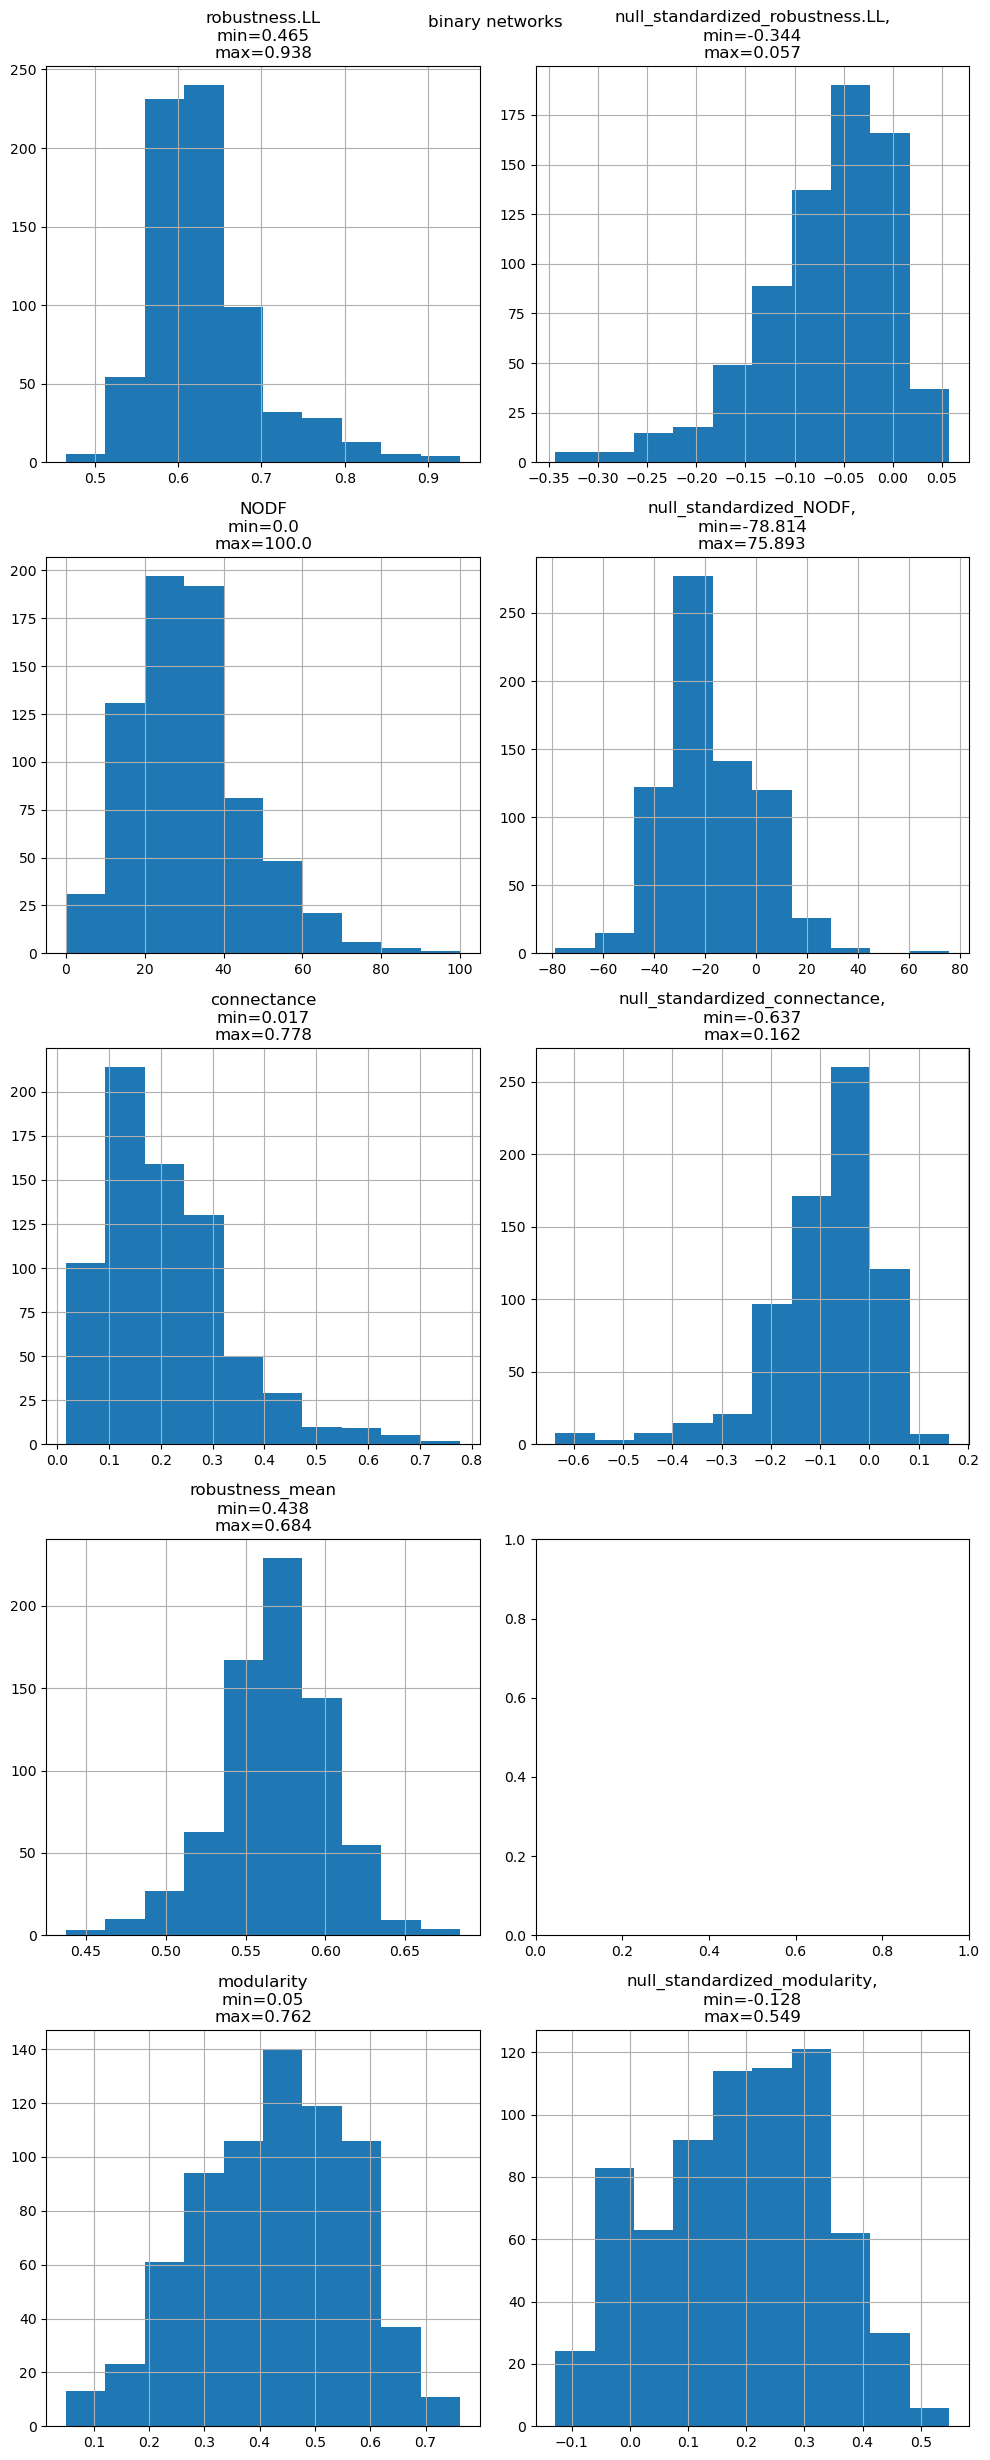

In [31]:
import matplotlib.pyplot as plt

features_to_examine = list(set(features_of_interest["network"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("binar")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"binary networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"null_standardized_{f}" in relevant_features.columns:
        relevant_features[f"null_standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"null_standardized_{f},\nmin={np.round(relevant_features[f'null_standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'null_standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{network_features_dir}/binary_networks_based_feature_distribution.jpeg")

features = ['robustness.LL', 'NODF', 'connectance', 'robustness_mean', 'modularity']


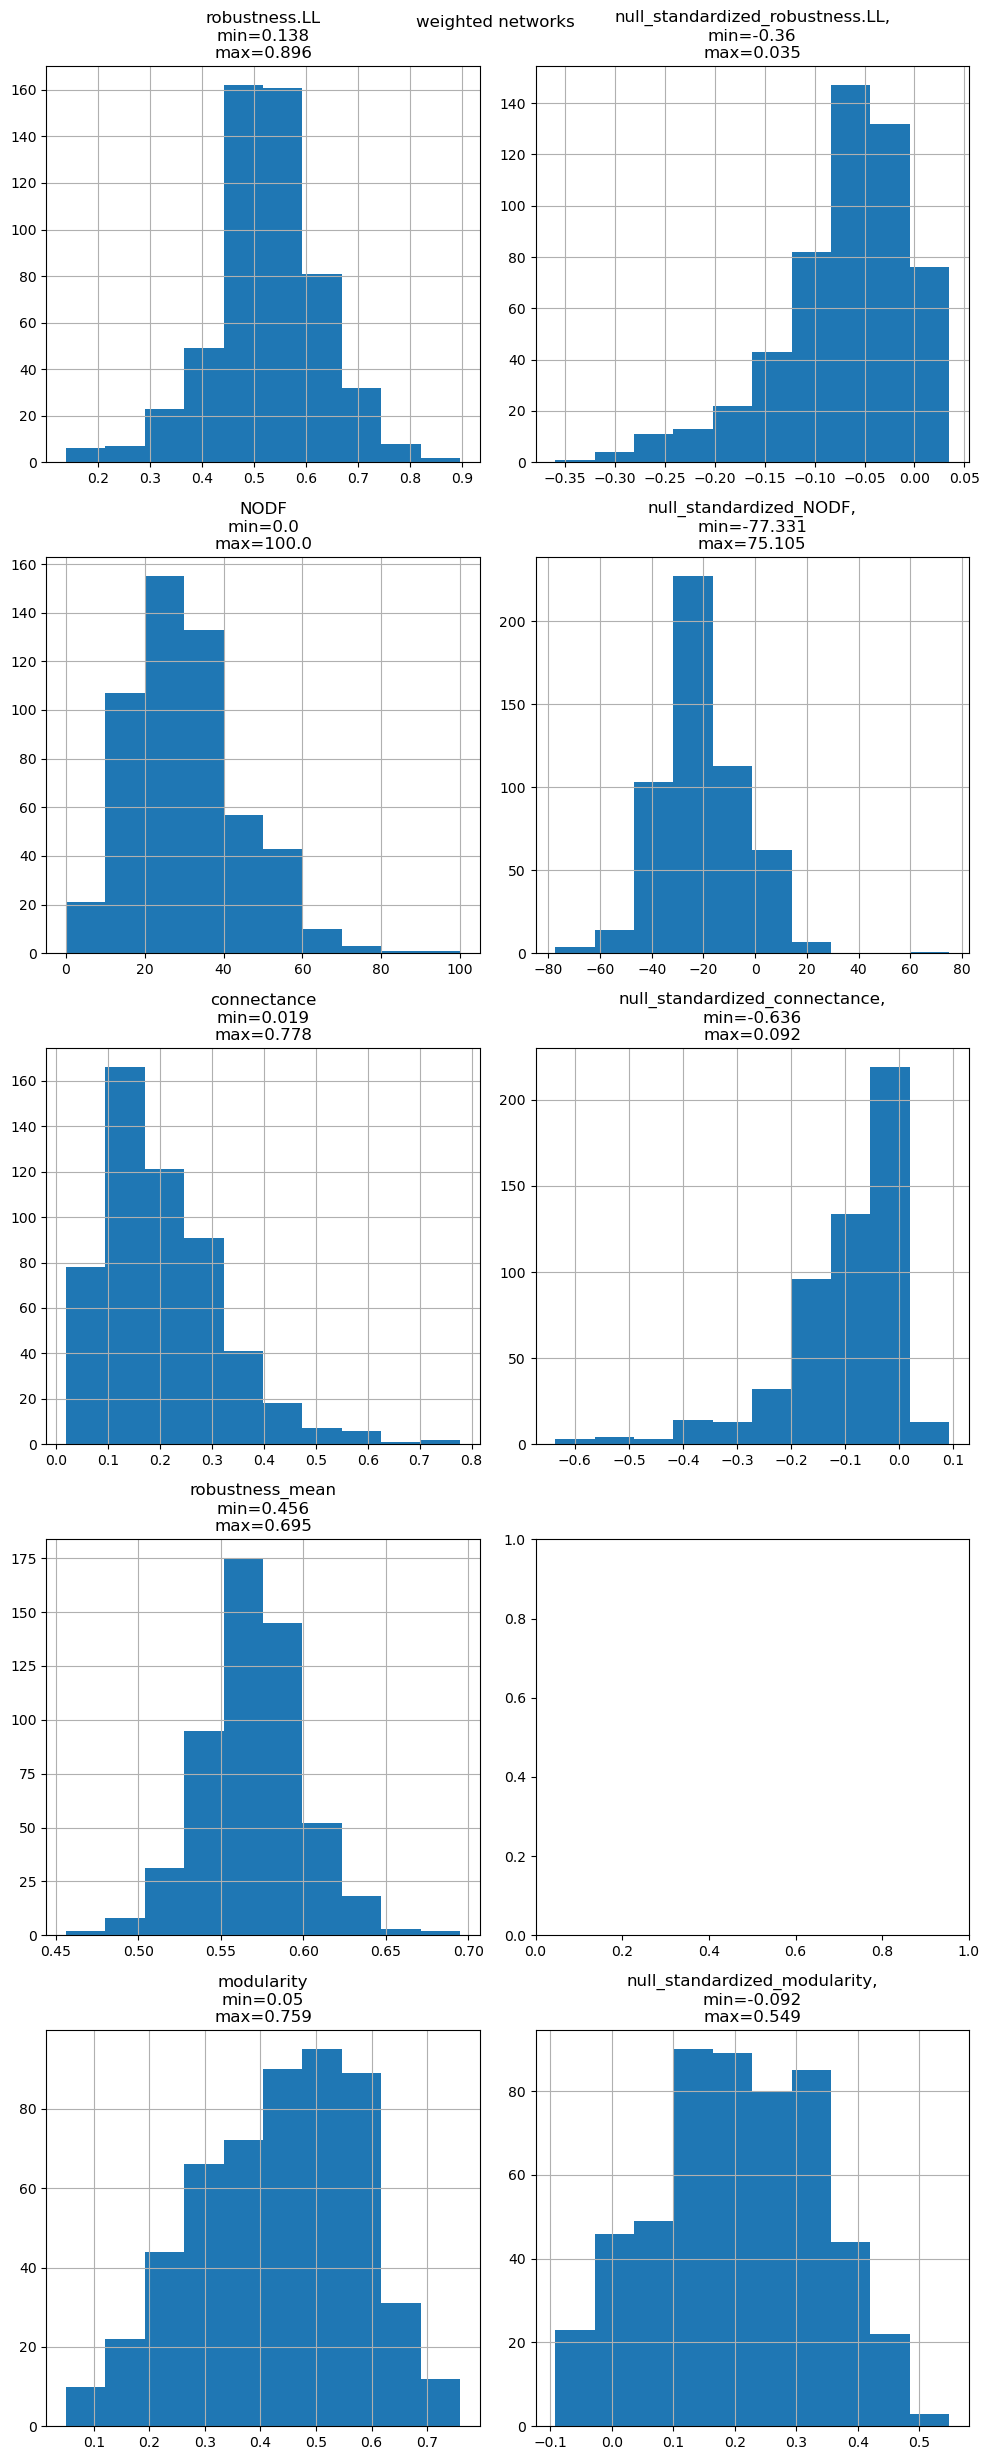

In [32]:
import matplotlib.pyplot as plt

features_to_examine = list(set(features_of_interest["network"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("weighted")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"weighted networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"null_standardized_{f}" in relevant_features.columns:
        relevant_features[f"null_standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"null_standardized_{f},\nmin={np.round(relevant_features[f'null_standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'null_standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{network_features_dir}/weighted_networks_based_feature_distribution.jpeg")